<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>



### Redes neuronales artificiales y convolucionales con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de una base de datos de imágenes satelitales. En concreto:
- Se implementará una red completamente conectada para establecer un modelo de referencia o <i>baseline</i>
- Se implementará una red convolucional
- Se implementará un autoencoder
- Se implementará una red convolucional profunda a partir de un modelo conocido (VGG16) pre-entrenado en Imagenet utilizando <i>transfer-learning</i>

## 0. Contexto y carga de librerías
Las imágenes tomadas por satélite son clave en la supervisión del uso y la cobertura del suelo, cuestiones relevantes para la gestión ambiental, la planificación urbana, la sostenibilidad y para combatir el cambio climático.

En esta práctica, trabajaremos con la base de datos [UC Merced Land Use Data](http://weegee.vision.ucmerced.edu/datasets/landuse.html), que consiste en imágenes satelitales de 256x256 píxeles de 21 escenas diferentes: las clases son diversas, conteniendo escenas e imágenes de aviones o ríos, entre otras categorías.

Concretamente trabajaremos con una versión aumentada de dicha base de datos que está disponible en un [repositorio de Kaggle](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification). En esta versión se han llevado a cabo varios procesos de aumentación de datos de tal forma que el número de imágenes por clase pasa de 100 a 500.

**Nota: Se recomienda realizar la práctica en el entorno que ofrece la plataforma Kaggle, ya que ofrece un entorno gratuito con 30 horas semanales de uso de GPU.**

A lo largo de toda la práctica, para la creación de las distintas redes, iremos alternando el uso del modelo [Sequential](https://keras.io/guides/sequential_model/) y el modelo [Functional](https://keras.io/guides/functional_api/) de Keras a través de las clases [Sequential](https://keras.io/api/models/sequential/) y [Model](https://keras.io/api/models/model/) respectivamente.

Empezamos cargando las librerías mas relevantes:

In [2]:
# Importamos tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.11.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Keras version   :  2.11.0


In [3]:
# Importamos los elementos de keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model

In [4]:
# Importamos el resto de librerías que necesitaremos para la PEC
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## 1. Descarga, análisis y pre-procesado de los datos

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Para la descarga de la base de datos tenemos 2 opciones dependiendo de si decidimos trabajar en local o desde el entorno de Kaggle:
- Si trabajamos en local debemos descargar la base de datos desde el siguiente [enlace](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/download?datasetVersionNumber=3) (es un archivo .zip que ocupa 2 GB) y descomprimirlo.
- Si trabajamos desde Kaggle. Debemos subir el Notebook del enunciado a la plataforma (para ello podéis seguir los 6 primeros pasos del siguiente [artículo](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) y después, una vez subido el notebook, clickar el botón '+ Add Data' y en la caja de búsqueda introducir la dirección 'https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification'. Una vez encontrado el dataset darle al botón '+' (Add Dataset), y desde ese momento ya tendréis accesible la base de datos en la ruta <code>../input/</code>.

Una vez tenemos la base de datos accesible vamos a inspeccionarla.

Las imágenes se encuentran agrupadas de 2 formas diferentes:
- En la carpeta <code>/landuse-scene-classification/images/</code> se encuentra el total de las imágenes separadas por clases (cada clase en una carpeta distinta). Pero no se ha realizado una separación en conjunto de entrenamiento y test (o entrenamiento, validación y test).
- En la carpeta <code>/landuse-scene-classification/images_train_test_val/</code> se encuentran 3 carpetas (<code>test</code>, <code>train</code> y <code>validation</code>) en las que el total de imágenes se ha separado de forma aleatoria. En cada una de las 3 carpetas, tenemos imágenes de las 21 clases agrupadas en sus correspondientes carpetas. En la carpeta raíz <code>/landuse-scene-classification/</code> tenemos 3 archivos .csv con la distribución de cada carpeta.

En esta práctica utilizaremos el dataset ya particionado, es decir, trabajaremos con las imágenes que se encuentran en la ruta <code>/landuse-scene-classification/images_train_test_val/</code>.

### 1.1. Análisis de los archivos .csv

A partir de los archivos .csv podemos ver cómo se han distribuído los datos. Por ejemplo:

In [5]:
train = pd.read_csv('../input/landuse-scene-classification/train.csv')
train.head(5)

Unnamed: 0                              Filename  Label     ClassName
0        5818              runway/runway_000259.png     16        runway
1        1327  intersection/intersection_000348.png     10  intersection
2        2529  agricultural/agricultural_000025.png      0  agricultural
3        3865        chaparral/chaparral_000195.png      5     chaparral
4        2024          airplane/airplane_000260.png      1      airplane

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <ul>
        <li>Extraer los nombres de las 21 clases (esto sólo hace falta hacerlo en uno de los 3 archivos)</li>
        <li>¿Cuántas instancias tenemos en total para cada conjunto de datos?</li>
        <li>Comprobar que las clases están balanceadas en los 3 conjuntos de datos (contando para cada conjunto, cuantas instancias/ejemplos tenemos para cada clase)</li>
    </ul>        
</div>

In [6]:
# Extraer nombres de las clases
clases = train['ClassName'].unique()
print(clases)

['runway' 'intersection' 'agricultural' 'chaparral' 'airplane'
 'storagetanks' 'tenniscourt' 'overpass' 'harbor' 'buildings'
 'mediumresidential' 'baseballdiamond' 'golfcourse' 'freeway'
 'sparseresidential' 'river' 'mobilehomepark' 'forest' 'beach'
 'parkinglot' 'denseresidential']


In [7]:
# Número de instancias por conjunto
test = pd.read_csv('../input/landuse-scene-classification/test.csv')
validation = pd.read_csv('../input/landuse-scene-classification/validation.csv')

In [7]:
print("Cantidad de instancias del conjunto train: ",train.shape[0])
print("Cantidad de instancias del conjunto test: ",test.shape[0])
print("Cantidad de instancias del conjunto de validation: ",validation.shape[0])

Cantidad de instancias del conjunto train:  7350
Cantidad de instancias del conjunto test:  1050
Cantidad de instancias del conjunto de validation:  2100


In [8]:
# Número de instancias por clase
print("Cantidad de instancias por clase del conjunto train:")
train.groupby('ClassName').size()

Cantidad de instancias por clase del conjunto train:


ClassName
agricultural         350
airplane             350
baseballdiamond      350
beach                350
buildings            350
chaparral            350
denseresidential     350
forest               350
freeway              350
golfcourse           350
harbor               350
intersection         350
mediumresidential    350
mobilehomepark       350
overpass             350
parkinglot           350
river                350
runway               350
sparseresidential    350
storagetanks         350
tenniscourt          350
dtype: int64

In [9]:
print("Cantidad de instancias por clase del conjunto test:")
test.groupby('ClassName').size()

Cantidad de instancias por clase del conjunto test:


ClassName
agricultural         50
airplane             50
baseballdiamond      50
beach                50
buildings            50
chaparral            50
denseresidential     50
forest               50
freeway              50
golfcourse           50
harbor               50
intersection         50
mediumresidential    50
mobilehomepark       50
overpass             50
parkinglot           50
river                50
runway               50
sparseresidential    50
storagetanks         50
tenniscourt          50
dtype: int64

In [10]:
print("Cantidad de instancias por clase del conjunto de validation:")
validation.groupby('ClassName').size()

Cantidad de instancias por clase del conjunto de validation:


ClassName
agricultural         100
airplane             100
baseballdiamond      100
beach                100
buildings            100
chaparral            100
denseresidential     100
forest               100
freeway              100
golfcourse           100
harbor               100
intersection         100
mediumresidential    100
mobilehomepark       100
overpass             100
parkinglot           100
river                100
runway               100
sparseresidential    100
storagetanks         100
tenniscourt          100
dtype: int64

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Podemos confirmar que, dentro de cada conjunto de datos: train, test y validacion, la cantidad de registros por cada clase está balanceada, ya que hay la misma cantidad para cada clase en cada grupo.
<br><br> 
</div>

### 1.2. Análisis de las carpetas de imágenes.

Aunque se supone que cada archivo .csv refleja a la perfección el contenido de cada conjunto de datos, no está demás cerciorarse que el contenido del mismo se corresponde con lo anotado en cada archivo. Para ello se pide:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Proporciona, a partir de las carpetas de imágenes, el número de imágenes que tenemos en cada categoría para cada conjunto de datos, comprobando que coincide con lo estipulado en el archivo .csv, y visualiza a modo de ejemplo una imagen por cada categoría. ¿Qué rango dinámico (valores mínimo y máximo) tienen las imágenes?
</div>

In [11]:
# Para el conjunto de datos de entrenamiento
dir_path = '../input/landuse-scene-classification/images_train_test_val/train'
for folder in os.listdir(dir_path): #entro a la carpeta train
    images_path=os.path.join(dir_path, folder) 
    print(str(folder)+': '+str(len(os.listdir(images_path)))+' images inside this folder')

airplane: 350 images inside this folder
tenniscourt: 350 images inside this folder
river: 350 images inside this folder
denseresidential: 350 images inside this folder
parkinglot: 350 images inside this folder
storagetanks: 350 images inside this folder
overpass: 350 images inside this folder
sparseresidential: 350 images inside this folder
mediumresidential: 350 images inside this folder
intersection: 350 images inside this folder
baseballdiamond: 350 images inside this folder
runway: 350 images inside this folder
chaparral: 350 images inside this folder
freeway: 350 images inside this folder
beach: 350 images inside this folder
buildings: 350 images inside this folder
harbor: 350 images inside this folder
mobilehomepark: 350 images inside this folder
forest: 350 images inside this folder
golfcourse: 350 images inside this folder
agricultural: 350 images inside this folder


La cantidad de imagenes en cada carpeta coincide con lo estipulado anteriormente para el archivo train.csv

Ejemplo de una imagen por cada categoria:

In [12]:
from PIL import Image

AIRPLANE
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


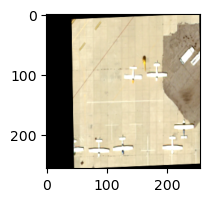

TENNISCOURT
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


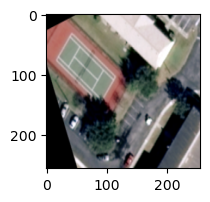

RIVER
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 247), (0, 251))


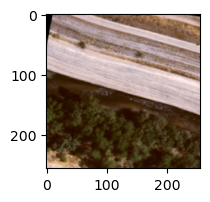

DENSERESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((13, 219), (14, 229), (16, 247))


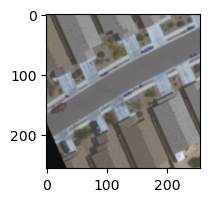

PARKINGLOT
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 229), (0, 229), (0, 229))


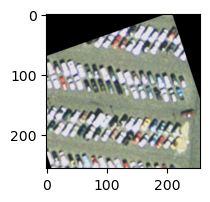

STORAGETANKS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


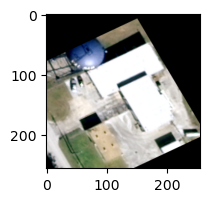

OVERPASS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


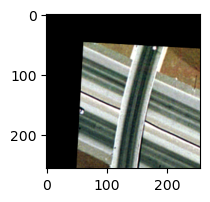

SPARSERESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 243), (0, 243), (0, 243))


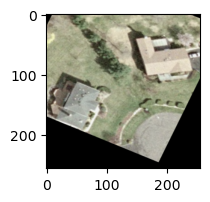

MEDIUMRESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((10, 214), (10, 215), (10, 214))


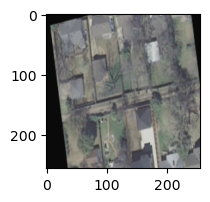

INTERSECTION
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((12, 255), (13, 255), (16, 255))


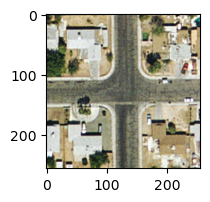

BASEBALLDIAMOND
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((38, 255), (68, 255), (59, 255))


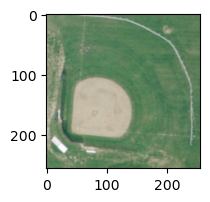

RUNWAY
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((60, 255), (70, 255), (62, 255))


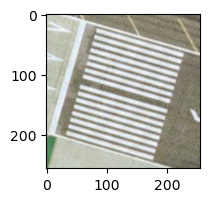

CHAPARRAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


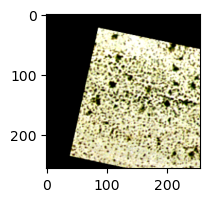

FREEWAY
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((11, 255), (25, 255), (30, 255))


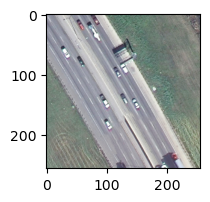

BEACH
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((29, 243), (29, 242), (29, 243))


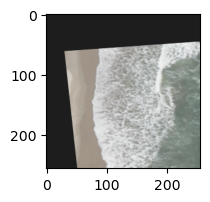

BUILDINGS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


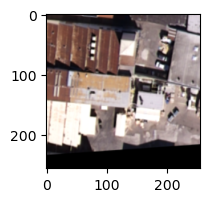

HARBOR
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((32, 255), (26, 255), (23, 255))


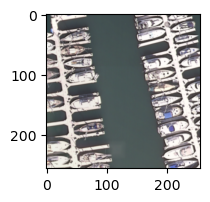

MOBILEHOMEPARK
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((20, 210), (20, 213), (20, 213))


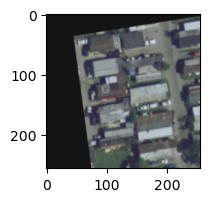

FOREST
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


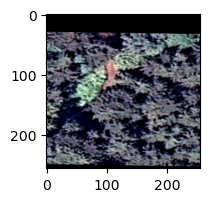

GOLFCOURSE
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((11, 255), (32, 255), (32, 254))


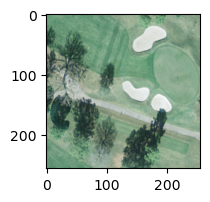

AGRICULTURAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


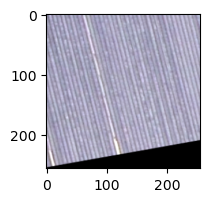

In [13]:
dir_path = '../input/landuse-scene-classification/images_train_test_val/train'
num=0
for folder in os.listdir(dir_path): #entro a la carpeta train
    images_path=os.path.join(dir_path, folder)
    for imagen in os.listdir(images_path):
        num+=1  
    print(folder.upper())
    im = Image.open(os.path.join(images_path,imagen) , 'r')
    print('Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen: ',im.getextrema())
    #img = plt.imread(os.path.join(images_path, imagen) 
    plt.figure(figsize=(2,2))
    plt.imshow(im)
    plt.show()

In [14]:
# Para el conjunto de datos de validación
dir_path = '../input/landuse-scene-classification/images_train_test_val/validation'
for folder in os.listdir(dir_path):
    images_path=os.path.join(dir_path, folder) 
    print(str(folder)+': '+str(len(os.listdir(images_path)))+' images inside this folder')

airplane: 100 images inside this folder
tenniscourt: 100 images inside this folder
river: 100 images inside this folder
denseresidential: 100 images inside this folder
parkinglot: 100 images inside this folder
storagetanks: 100 images inside this folder
overpass: 100 images inside this folder
sparseresidential: 100 images inside this folder
mediumresidential: 100 images inside this folder
intersection: 100 images inside this folder
baseballdiamond: 100 images inside this folder
runway: 100 images inside this folder
chaparral: 100 images inside this folder
freeway: 100 images inside this folder
beach: 100 images inside this folder
buildings: 100 images inside this folder
harbor: 100 images inside this folder
mobilehomepark: 100 images inside this folder
forest: 100 images inside this folder
golfcourse: 100 images inside this folder
agricultural: 100 images inside this folder


La cantidad de imagenes en cada carpeta coincide con lo estipulado anteriormente para el archivo validation.csv

AIRPLANE
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


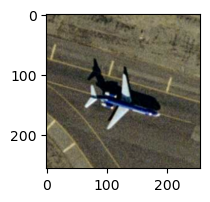

TENNISCOURT
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((15, 255), (30, 255), (27, 255))


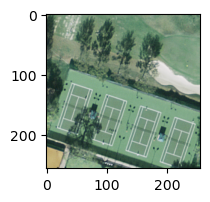

RIVER
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 228), (0, 202), (0, 212))


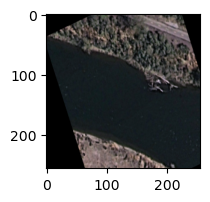

DENSERESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


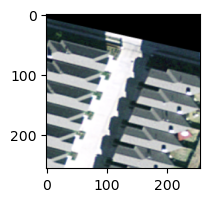

PARKINGLOT
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 237), (0, 237), (0, 232))


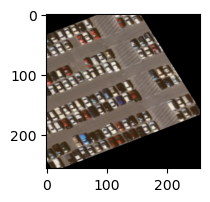

STORAGETANKS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (2, 255), (9, 255))


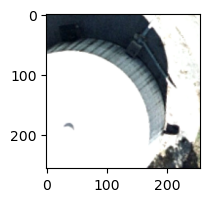

OVERPASS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


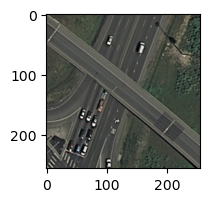

SPARSERESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 211), (0, 211), (0, 211))


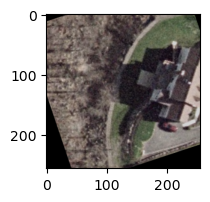

MEDIUMRESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


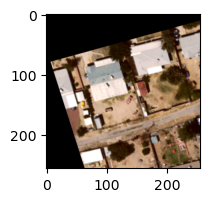

INTERSECTION
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((14, 240), (14, 240), (14, 240))


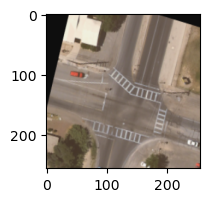

BASEBALLDIAMOND
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 241), (0, 255), (0, 255))


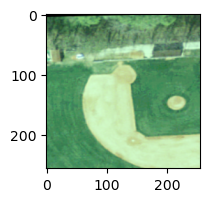

RUNWAY
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((50, 255), (38, 255), (23, 255))


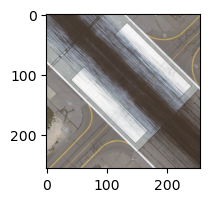

CHAPARRAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


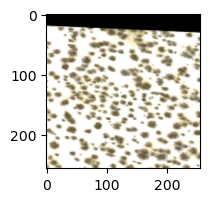

FREEWAY
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 219), (0, 215), (0, 214))


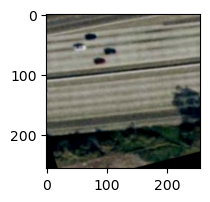

BEACH
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 252), (0, 250), (0, 252))


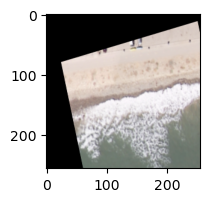

BUILDINGS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 203), (0, 201), (0, 201))


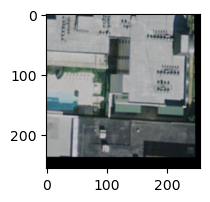

HARBOR
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


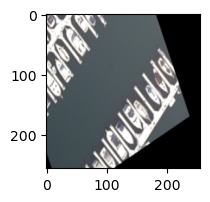

MOBILEHOMEPARK
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


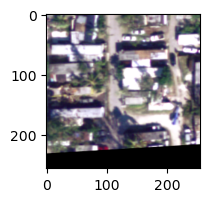

FOREST
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 188), (0, 193), (0, 188))


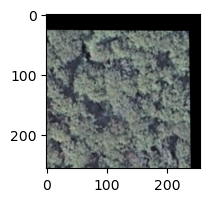

GOLFCOURSE
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


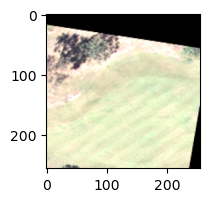

AGRICULTURAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 241), (0, 235), (0, 235))


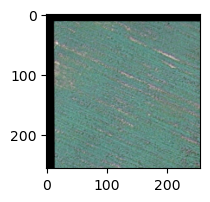

In [15]:
dir_path = '../input/landuse-scene-classification/images_train_test_val/validation'
num=0
for folder in os.listdir(dir_path): #entro a la carpeta validation
    images_path=os.path.join(dir_path, folder)
    for imagen in os.listdir(images_path):
        num+=1  
    print(folder.upper())
    im = Image.open(os.path.join(images_path,imagen) , 'r')
    print('Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen: ',im.getextrema())
    #img = plt.imread(os.path.join(images_path, imagen) )
    plt.figure(figsize=(2,2))
    plt.imshow(im)
    plt.show()

In [16]:
# Para el conjunto de datos de test
dir_path = '../input/landuse-scene-classification/images_train_test_val/test'
for folder in os.listdir(dir_path): #entro a la carpeta test
    images_path=os.path.join(dir_path, folder) 
    print(str(folder)+': '+str(len(os.listdir(images_path)))+' images inside this folder')

airplane: 50 images inside this folder
tenniscourt: 50 images inside this folder
river: 50 images inside this folder
denseresidential: 50 images inside this folder
parkinglot: 50 images inside this folder
storagetanks: 50 images inside this folder
overpass: 50 images inside this folder
sparseresidential: 50 images inside this folder
mediumresidential: 50 images inside this folder
intersection: 50 images inside this folder
baseballdiamond: 50 images inside this folder
runway: 50 images inside this folder
chaparral: 50 images inside this folder
freeway: 50 images inside this folder
beach: 50 images inside this folder
buildings: 50 images inside this folder
harbor: 50 images inside this folder
mobilehomepark: 50 images inside this folder
forest: 50 images inside this folder
golfcourse: 50 images inside this folder
agricultural: 50 images inside this folder


La cantidad de imagenes en cada carpeta coincide con lo estipulado anteriormente para el archivo test.csv

AIRPLANE
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


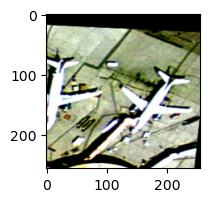

TENNISCOURT
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


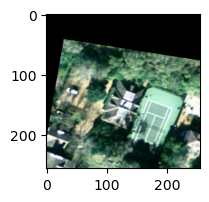

RIVER
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((14, 199), (14, 197), (14, 199))


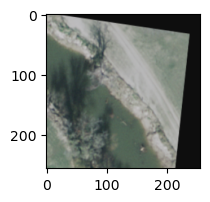

DENSERESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 252), (0, 254), (0, 254))


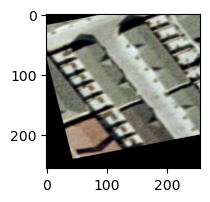

PARKINGLOT
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


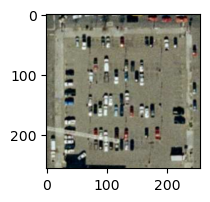

STORAGETANKS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (7, 255), (0, 255))


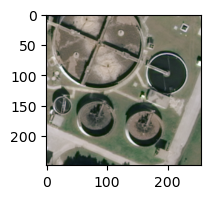

OVERPASS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 216), (0, 216), (0, 216))


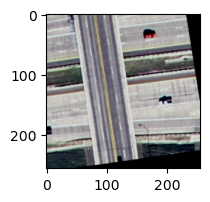

SPARSERESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((1, 255), (1, 255), (1, 255))


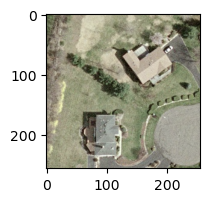

MEDIUMRESIDENTIAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


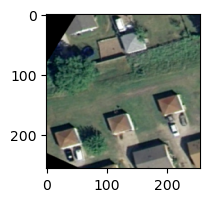

INTERSECTION
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 251))


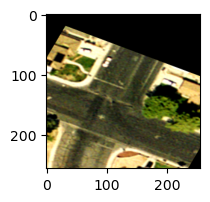

BASEBALLDIAMOND
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 241), (0, 255), (0, 255))


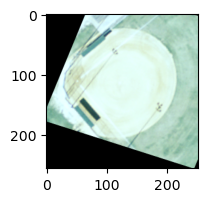

RUNWAY
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


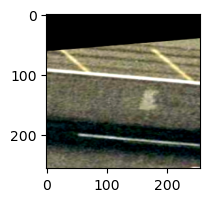

CHAPARRAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


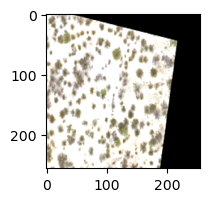

FREEWAY
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 250))


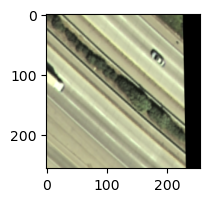

BEACH
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((81, 255), (106, 255), (79, 255))


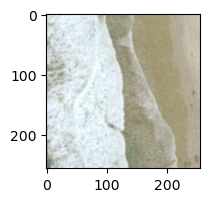

BUILDINGS
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((9, 255), (13, 255), (12, 255))


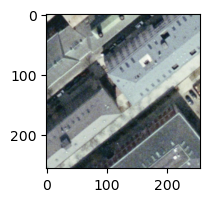

HARBOR
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 221), (0, 221), (0, 221))


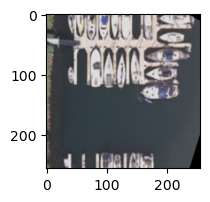

MOBILEHOMEPARK
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 255), (0, 255), (0, 255))


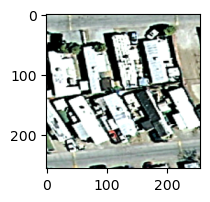

FOREST
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 241), (0, 241), (0, 239))


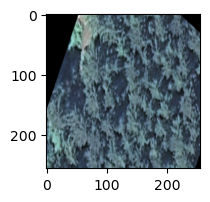

GOLFCOURSE
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((23, 255), (35, 255), (32, 255))


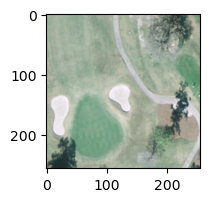

AGRICULTURAL
Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen:  ((0, 236), (0, 255), (0, 245))


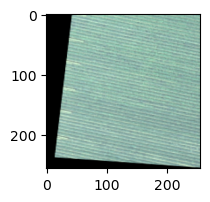

In [17]:
dir_path = '../input/landuse-scene-classification/images_train_test_val/test'
num=0
for folder in os.listdir(dir_path): #entro a la carpeta test
    images_path=os.path.join(dir_path, folder)
    for imagen in os.listdir(images_path):
        num+=1  
    print(folder.upper())
    im = Image.open(os.path.join(images_path,imagen) , 'r')
    print('Rango dinámico: Valor mínimo y máximo de cada banda RGB de la imagen: ',im.getextrema())
    #img = plt.imread(os.path.join(images_path, imagen) )
    plt.figure(figsize=(2,2))
    plt.imshow(im)
    plt.show()

### 1.3. Creación de los conjuntos de datos en formato Keras/Tensorflow
​
Con el objetivo de crear una base de datos en el formato Keras/Tensorflow a partir de las imágenes proporcionadas utilizaremos la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> ya que nos permite crear bases de datos a partir de imágenes guardadas en carpetas.

La documentación de esta función se encuentra tanto en la web de [Keras](https://keras.io/api/data_loading/image/) como en la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) .

Además, aprovecharemos para redimensionar las imágenes y pasarlas a tamaño 224x224, que es el tamaño con el que se ha entrenado la red VGG16 que utilizaremos en un apartado posterior.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Utiliza la función  <code>image_dataset_from_directory()</code> para generar 3 conjuntos de datos (<code>train_data</code>, <code>val_data</code> y <code>test_data</code>) a partir de las carpetas analizadas. Las imágenes deben ser redimensionadas a tamaño 224x224 píxels RGB (224,224,3) y agrupadas en lotes de tamaño 32 (batch=32) manteniendo su rango dinámico.
</div>

In [18]:
list(clases)

['runway',
 'intersection',
 'agricultural',
 'chaparral',
 'airplane',
 'storagetanks',
 'tenniscourt',
 'overpass',
 'harbor',
 'buildings',
 'mediumresidential',
 'baseballdiamond',
 'golfcourse',
 'freeway',
 'sparseresidential',
 'river',
 'mobilehomepark',
 'forest',
 'beach',
 'parkinglot',
 'denseresidential']

In [8]:
directory = '../input/landuse-scene-classification/images_train_test_val/train'

train_data = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    class_names=list(clases),
    color_mode="rgb",
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=123,
) 

Found 7350 files belonging to 21 classes.


In [20]:
#Chequeo el rango dinamico:
count=0
for batch in train_data.take(-1):
    dynamic_range = tf.math.reduce_max(batch[0]) - tf.math.reduce_min(batch[0])
    if dynamic_range == 255:
        count = count+1
        
if count == len(train_data):
    print('El rango dinamico es 255')

El rango dinamico es 255


In [9]:
directory = '../input/landuse-scene-classification/images_train_test_val/validation'

val_data = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    class_names=list(clases),
    color_mode="rgb",
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=123,
)

Found 2100 files belonging to 21 classes.


In [22]:
#Chequeo el rango dinamico:
count=0
for batch in val_data.take(-1):
    dynamic_range = tf.math.reduce_max(batch[0]) - tf.math.reduce_min(batch[0])
    if dynamic_range == 255:
        count = count+1
        
if count == len(val_data):
    print('El rango dinamico es 255')

El rango dinamico es 255


In [10]:
directory = '../input/landuse-scene-classification/images_train_test_val/test'

test_data = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    class_names=list(clases),
    color_mode="rgb",
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    seed=123,
)

Found 1050 files belonging to 21 classes.


In [24]:
#Chequeo el rango dinamico:
count=0
for batch in test_data.take(-1):
    dynamic_range = tf.math.reduce_max(batch[0]) - tf.math.reduce_min(batch[0])
    if dynamic_range == 255:
        count = count+1
        
if count == len(test_data):
    print('El rango dinamico es 255')

El rango dinamico es 255


## 2. Modelo ANN

En este apartado, vamos a entrenar y evaluar un modelo muy sencillo completamente conectado para establecer un resultado de referencia.

Dado que en una red neuronal artificial las entradas son unidimensionales, lo primero que tenemos que hacer es redimensionar los datos de entrada (las imágenes) para convertirlos en arrays de una dimensión.

Como trabajar con imágenes de tamaño 224x224 en una red completamente conectada implicaría entrenar un número de parámetros excesivamente elevado definiremos un modelo en el que se realizará previamente un redimensionado de las imágenes de entrada a un tamaño de 32x32 y un achatamiento (*flattening*) de los píxeles para así generar un vector unidimensional de tamaño 3072 (32x32x3). 

Posteriormente entrenaremos un clasificador (una red completamente conectada) para llevar a cabo la clasificación de nuestros datos.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes especificaciones:
    <ul>
        <li>Una capa que reduzca las dimensiones de entrada de (224,224) a (32,32)</li>
        <li>Una capa de reescalado para conseguir que los valores de la imagen estén entre 0 y 1</li>
        <li>Una capa Flatten para convertir la imagen en un vector de 3072 posiciones</li>
        <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
        <li>Una capa de Dropout (con probabilidad 0.5)</li>
        <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
    </ul>
        
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación. NOTA: Se recomienda hacer una función que imprima ambas gráficas para poder reutilizarla en próximos apartados.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.<br/>    
    <strong> NOTA: se recomienda, al final de la creación de cada modelo, utilizar la función <code>summary()</code> para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.</strong>
</div>

In [25]:
# Definición de la red
model = tf.keras.Sequential() #Instancio el modelo secuencial
model.add(tf.keras.layers.Input(shape=[224,224,3])) #Capa de entrada
model.add(tf.keras.layers.Resizing(32,32)) #Capa resizing para reducir dimensiones
model.add(tf.keras.layers.Rescaling(1./255, offset=0.0)) #Capa de re escalado entre [0,1]
model.add(tf.keras.layers.Flatten()) #Capa flatten
model.add(tf.keras.layers.Dense(1024,activation='relu')) #Capa completamente conectada con activacion RELU
model.add(tf.keras.layers.Dropout(0.5)) #Capa de dropuot
model.add(tf.keras.layers.Dense(21,activation=tf.keras.activations.softmax)) #Capa de salida completamente conectada

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 21)                21525     
                                                                 
Total params: 3,168,277
Trainable params: 3,168,277
Non-

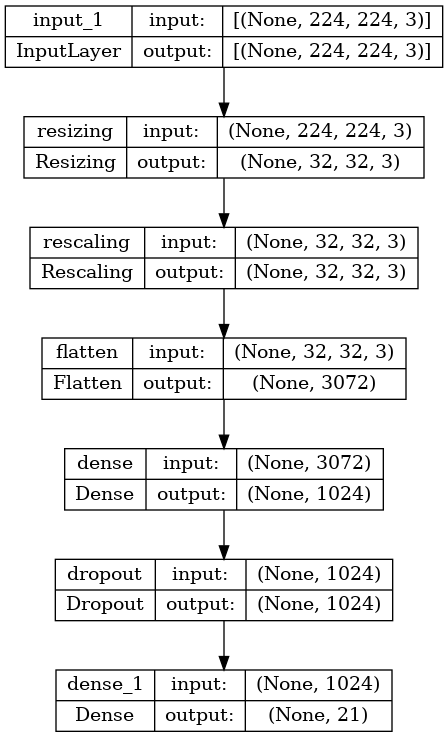

In [27]:
keras.utils.plot_model(model,show_shapes=True)

In [28]:
# Compilación de la red: After a model is created, you must call its compile() method to specify the loss function and the optimizer to use
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [32]:
# Entrenamiento de la red
import time
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_weights_1.h5', 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         mode='max', 
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                           patience=10)

start_time = time.time()
history = model.fit(train_data,
                    epochs=100,
                    validation_data=(val_data),
                    callbacks=[checkpoint_callback, early_stopping_callback])
end_time = time.time()

training_time = end_time - start_time

Epoch 1/100
229/230 [============================>.] - ETA: 0s - loss: 2.9324 - accuracy: 0.1107
Epoch 1: val_accuracy improved from -inf to 0.12381, saving model to best_model_weights_1.h5
230/230 [==============================] - 26s 109ms/step - loss: 2.9323 - accuracy: 0.1107 - val_loss: 2.9216 - val_accuracy: 0.1238
Epoch 2/100
229/230 [============================>.] - ETA: 0s - loss: 2.8823 - accuracy: 0.1288
Epoch 2: val_accuracy did not improve from 0.12381
230/230 [==============================] - 26s 111ms/step - loss: 2.8820 - accuracy: 0.1288 - val_loss: 2.8919 - val_accuracy: 0.1238
Epoch 3/100
229/230 [============================>.] - ETA: 0s - loss: 2.8437 - accuracy: 0.1447
Epoch 3: val_accuracy did not improve from 0.12381
230/230 [==============================] - 30s 127ms/step - loss: 2.8436 - accuracy: 0.1449 - val_loss: 2.8566 - val_accuracy: 0.1224
Epoch 4/100
229/230 [============================>.] - ETA: 0s - loss: 2.8049 - accuracy: 0.1520
Epoch 4: val_ac

In [33]:
#Pesos que mejor resultado dieron:
model.load_weights('best_model_weights_1.h5')

In [34]:
print("Training time: {} seconds".format(round(training_time,2)))

Training time: 3077.57 seconds


In [11]:
def plot_neural_network(model_history):
    # Visualizamos la evolución de la accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

    # Visualizamos la evolución del error cometido por la red
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

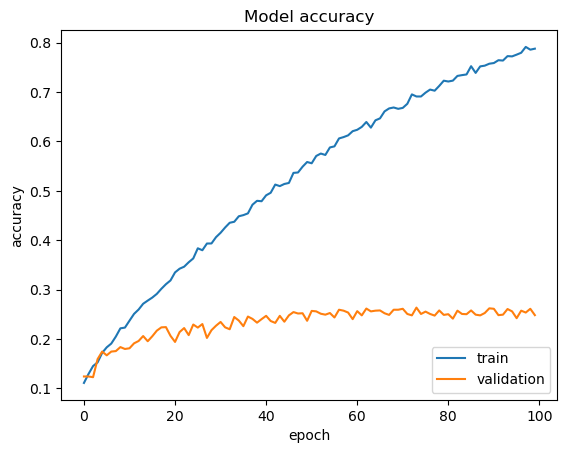

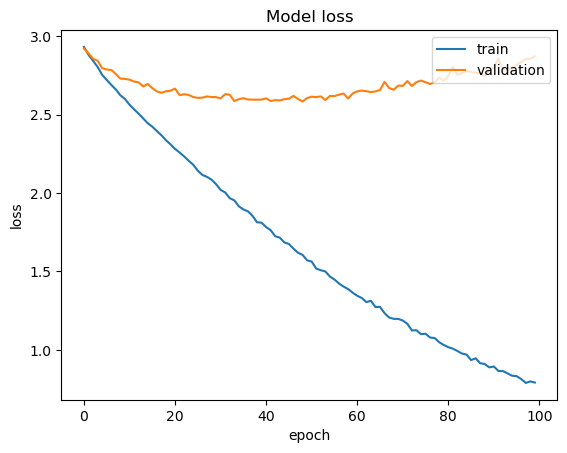

In [36]:
plot_neural_network(history)

In [37]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = model.evaluate(test_data)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

33/33 [==============================] - 3s 67ms/step - loss: 2.7545 - accuracy: 0.2476
Test loss: 2.7544753551483154
Test accuracy: 0.24761904776096344


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
   - Observando los gráficos podemos ver que la métrica ´accuracy´ del modelo con el set de entramiento aumenta a medida que las épocas aumentan, pero evaluándola con el set de validación se mantiene dentor de un rango a partir de aprox 40 épocas. A su vez, en cuanto a la métrica ´loss´ vemos que a medida que aumentan las épocas se va reduciendo con el set de entrenamiento, pero con el set de validación se queda en aproximadamente el mismo valor. Con esta información podemos concluir que el modelo no performa bien, y que está sobre entrenado, es decir que no es capaz de generalizar para datos con los que no fue entrenado, ya que la evaluación con los datos de entrenamiento está correcta pero con los datos de validación no. 
    <br>
   - Utilizando el modelo con los datos de test, corroboramos que el rendimiento del modelo no es bueno, nos da un accuracy de 0,24 y loss de 2,75. 
    <br>
   - En cuanto al tiempo de entrenamiento, el modelo tardó 3077 segundos.
    <br>
   - La cantidad de parámetros a entrenar es de 3.168.277: 3.146.752 corresponden a la primer capa totalmente conectada y 21.525 a la segunda. 
<br><br>
</div>

## 3. Red convolucional pequeña

Dadas las bajas prestaciones del modelo anterior vamos a probar otro tipo de redes con el objetivo de obtener unos mejores resultados en la tarea de clasificación que debemos llevar a cabo.

Las redes convolucionales (CNN) son especialmente adecuadas para modelar datos donde hay patrones en 2 dimensiones, como es el caso de las imágenes.

En la tarea de clasificación, la estructura de una CNN se divide en dos grandes bloques:

* **Bloque extractor de características**: En este bloque se generan diferentes niveles de abstracción de la imagen de entrada mediante capas convolucionales. Cuanto más profundas son estas capas, más preparadas están para la tarea de clasificación.
* **Clasificador**: Este bloque está formado por capas totalmente conectadas, la salida de deste bloque será la probabilidad asociada a cada clase.

En el apartado anterior, el bloque "extractor de características" era extremadamente simple, por no decir inexistente. En este apartado, vamos a hacer uso de capas convolucionales para poder aprender mejores abstracciones de las imágenes de entrada con el fin de mejorar su clasificación.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.

**Nota: Se recomienda, a partir de este punto realizar el entrenamiento en una máquina con GPU (puede activarse en plataformas como Google Colab o Kaggle) con el fin de reducir los tiempos de entrenamiento.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [2 puntos]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa una red con las siguientes características:
    <ul>
        <li>Un bloque extractor de características que conste de:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>Una capa de rescalado para conseguir que los valores de la imagen estén entre 0 y 1.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
                <li>Una capa de <i>average pooling</i> (GlobalAveragePooling2D) para reducir las dimensiones a un vector de 1024 dimensiones.</li>
            </ul></li>
        <li>El clasificador final sigue la estructura del modelo del apartado anterior:
            <ul>
                <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
                <li>Una capa de Dropout (con probabilidad 0.5)</li>
                <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
          <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de <i>accuracy</i> y <i>loss</i>. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [38]:
# Definición de la red
inputs = keras.Input(shape=[224,224,3]) #Capa de entrada
rescaling_layer = tf.keras.layers.Rescaling(1./255, offset=0.0) #Capa de re escalado entre [0,1]
conv1_layer = tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), activation="relu",padding="same")  #La cantid de filtros serian las distintas caracteristicas que filtramos con cada kernel (mapa de caract)
max1_pooling = tf.keras.layers.MaxPooling2D()
conv2_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), activation="relu",padding="same")
max2_pooling = tf.keras.layers.MaxPooling2D()
conv3_layer = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same")
max3_pooling = tf.keras.layers.MaxPooling2D()
average_pooling = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(1024,activation='relu') #Capa completamente conectada con activacion RELU
dropout_layer = tf.keras.layers.Dropout(0.5) #Capa de dropuot
output_layer = tf.keras.layers.Dense(21,activation=tf.keras.activations.softmax) #Capa de salida completamente conectada

rescaling = rescaling_layer(inputs)
hidden1 = conv1_layer(rescaling)
hidden2 = max1_pooling(hidden1)
hidden3 = conv2_layer(hidden2)
hidden4 = max2_pooling(hidden3)
hidden5 = conv3_layer(hidden4)
hidden6 = max3_pooling(hidden5)
average = average_pooling(hidden6)
dense = dense_layer(average)
dropout = dropout_layer(dense)
output = output_layer(dropout)

model2 = tf.keras.Model(inputs=[inputs], outputs=[output])
print(model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                         

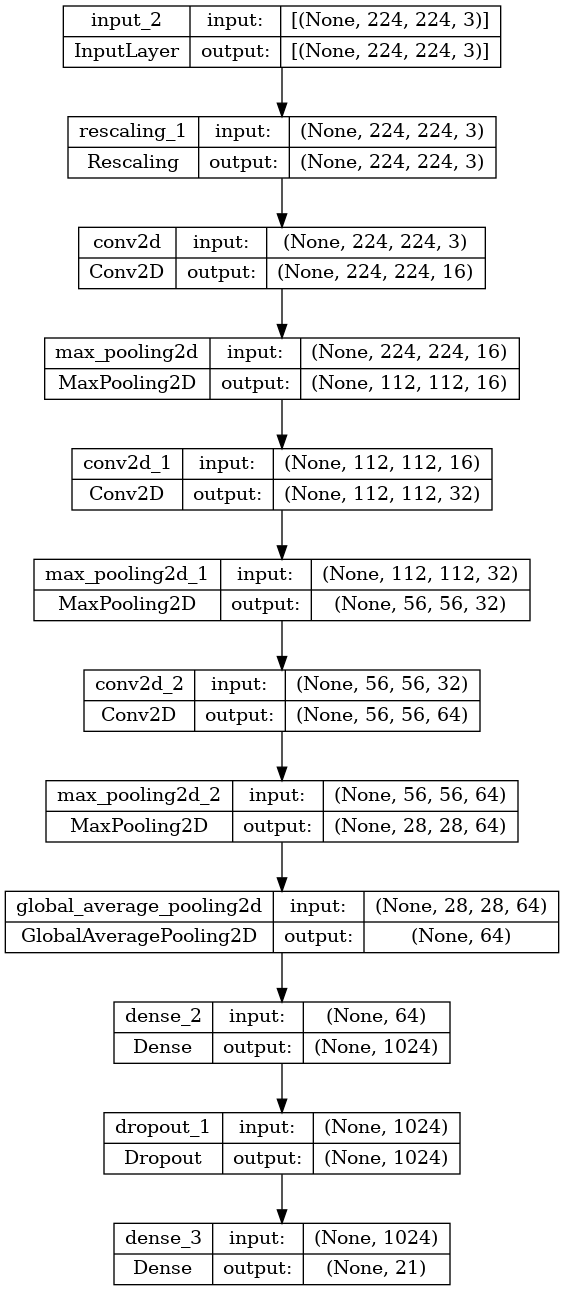

In [39]:
keras.utils.plot_model(model2,show_shapes=True)

In [41]:
# Compilación de la red
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [42]:
# Entrenamiento de la red

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_weights_2.h5', 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         mode='max', 
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                           patience=10)

start_time = time.time()
history = model2.fit(train_data,
                    epochs=100,
                    validation_data=(val_data),
                    callbacks=[checkpoint_callback, early_stopping_callback])
end_time = time.time()

training_time = end_time - start_time

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 2.8690 - accuracy: 0.0937
Epoch 1: val_accuracy improved from -inf to 0.17429, saving model to best_model_weights_2.h5
230/230 [==============================] - 33s 121ms/step - loss: 2.8690 - accuracy: 0.0937 - val_loss: 2.5897 - val_accuracy: 0.1743
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 2.5003 - accuracy: 0.1867
Epoch 2: val_accuracy improved from 0.17429 to 0.22571, saving model to best_model_weights_2.h5
230/230 [==============================] - 28s 119ms/step - loss: 2.5003 - accuracy: 0.1867 - val_loss: 2.3285 - val_accuracy: 0.2257
Epoch 3/100
230/230 [==============================] - ETA: 0s - loss: 2.2151 - accuracy: 0.2773
Epoch 3: val_accuracy improved from 0.22571 to 0.31952, saving model to best_model_weights_2.h5
230/230 [==============================] - 27s 115ms/step - loss: 2.2151 - accuracy: 0.2773 - val_loss: 2.0951 - val_accuracy: 0.3195
Epoch 4/100
230/230 [=

In [43]:
#Pesos que mejor resultado dieron:
model2.load_weights('best_model_weights_2.h5')

In [44]:
print("Training time: {} seconds".format(round(training_time,2)))

Training time: 2985.42 seconds


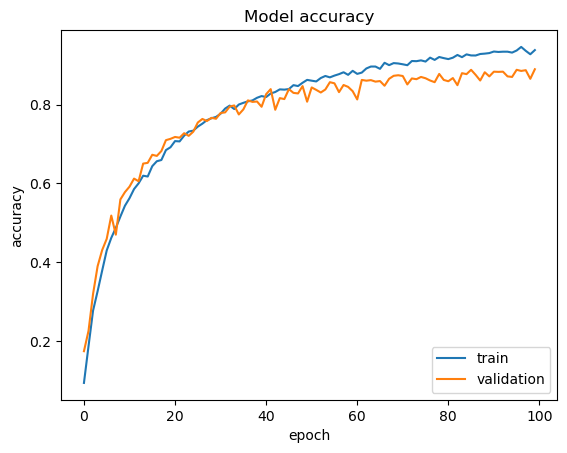

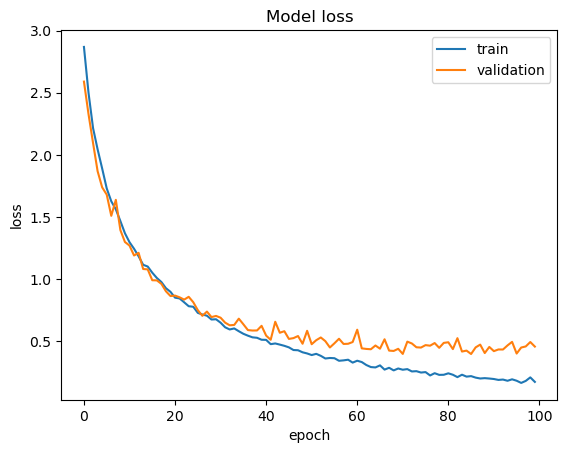

In [45]:
# Resultados
plot_neural_network(history)

In [46]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = model2.evaluate(test_data)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

33/33 [==============================] - 3s 79ms/step - loss: 0.4371 - accuracy: 0.8771
Test loss: 0.43705710768699646
Test accuracy: 0.8771428465843201


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong> Comentarios </strong>
<br><br>
    El tiempo de entrenamiento fue de 2985 segundos, es decir 49 minutos y la cantidad de parámetros a entrenar se redujo a 112.437.
    <br>
    En cuanto a las métricas de accuracy y loss, utilizando una red convolucional pequeña vemos una mejora en ambas, la exactitud evaluando el modelo con los datos de test dio 0.877, mucho mejor que con el modelo anterior, y la métrica loss dio 0.43, también mejor que con el modelo anterior.
    <br>
    En los gráficos podemos ver cómo el accuracy aumenta tanto con los datos de entranamiento como con los de validación, siendo el valor de validación levemente menor que el de entrenamiento, pero manteniendose en un rango adecuado, lo cual indica que el modelo ha podido generalizar a datos con los que no había sido entrenado.
    En cuanto a la métrica loss vemos que al aumentar las épocas se va redujendo para ambos conjuntos de datos.
<br><br>
</div>

## 4. Autoencoders
En el apartado anterior hemos podido observar que, utilizando el tipo de redes adecuado, podemos obtener mejores resultados entrenando un número de parámetros muy inferior. Esto es debido a que las CNN consiguen extraer las características principales de los datos proporcionados (imágenes en nuestro caso).

En este apartado vamos a observar esta capacidad desde otro punto de vista: el de **codificar y decodificar una imagen**.

Para ello diseñaremos un autoencoder que sea capaz de reducir el tamaño de los datos de entrada pero captando las características principales de las imágenes para poder llevar a cabo una buena reconstrucción de las mismas.

Empezaremos rescalando externamente los datos que vamos a utilizar, para que estén en el rango (0,1), en lugar de realizarlo dentro de la red como hemos hecho en el apartado anterior:

In [18]:
# data rescalling
normalization_layer = Rescaling(1./255)

normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

Además, en un autoencoder, en lugar de utilizar las etiquetas como objetivo (que es lo que se utiliza en un problema de clasificación), deben ser las propias imágenes las que se utilicen como objetivo de la red. Por tanto, crearemos una nueva base de datos de entrenamiento y validación donde son las propias imágenes las que hagan de etiquetas:

In [19]:
train_data_auto = normalized_train_data.map(lambda x, y: (x, x))
val_data_auto = normalized_val_data.map(lambda x, y: (x, x))

Comprobamos la estructura de la nueva base de datos:

In [20]:
image_batch, label_batch = iter(train_data_auto).get_next()
print("Las dimensiones de un batch de imágenes es: {}".format(image_batch.shape))
print("Las dimensiones de un batch de etiquetas es: {}".format(label_batch.shape))

Las dimensiones de un batch de imágenes es: (32, 224, 224, 3)
Las dimensiones de un batch de etiquetas es: (32, 224, 224, 3)


Y que los datos tienen el rango dinámico adecuado:

In [21]:
first_image = image_batch[0]
print("En la primera imagen los valores mínimo y máximo son {} y {}, respectivamente"
      .format(np.min(first_image),np.max(first_image)))

En la primera imagen los valores mínimo y máximo son 0.09019608050584793 y 0.7843137979507446, respectivamente


### 4.1. Diseño y entrenamiento del autoencoder

Una vez ya tenemos los datos en el formato adecuado vamos a diseñar el autoencoder. Para ello utilizaremos el bloque extractor del apartado anterior como codificador y reflejaremos su estructura en el decodificador utilizando las capas [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) y [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) de keras.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa un autoencoder con las siguientes características:
    <ul>
        <li>El bloque codificador debe tener:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
            </ul></li>
        <li>El bloque decodificador debe tener:
            <ul>
                <li>3 capas convolucionales con tamaño de kernel (3x3) para las 2 primeras y (5x5) para la última. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 64, 32 y 16, respectivamente</li>
                <li>A cada capa convolucional le sigue una capa de <i>UpSampling2D</i></li>
                <li>Una última capa convolucional con tamaño de kernel (3x3), con 3 filtros y activación sigmoide.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
         <li>Utilizar como función de pérdida el error cuadrático medio.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la pérdida durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas del <i>loss</i> (la curva de entrenamiento y la de validación).</li>
    </ul>
</div>



In [40]:
# Definición de la red
# Bloque codificador:
inputs = keras.Input(shape=[224,224,3]) #Capa de entrada
cod_conv1_layer = tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5), activation="relu",padding="same")  #La cantid de filtros serian las distintas caracteristicas que filtramos con cada kernel (mapa de caract)
cod_max1_pooling = tf.keras.layers.MaxPooling2D()
cod_conv2_layer = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3), activation="relu",padding="same")
cod_max2_pooling = tf.keras.layers.MaxPooling2D()
cod_conv3_layer = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same")
cod_max3_pooling = tf.keras.layers.MaxPooling2D()

# Bloque decodificador:
decod_conv1_layer = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3), activation="relu",padding="same")  
decod_sampling1_layer = tf.keras.layers.UpSampling2D()
decod_conv2_layer = tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(3,3), activation="relu",padding="same")  
decod_sampling2_layer = tf.keras.layers.UpSampling2D()
decod_conv3_layer = tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(5,5), activation="relu",padding="same")  
decod_sampling3_layer = tf.keras.layers.UpSampling2D()
output_layer = tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=(3,3), activation="sigmoid",padding="same")


hidden1 = cod_conv1_layer(inputs)
hidden2 = cod_max1_pooling(hidden1)
hidden3 = cod_conv2_layer(hidden2)
hidden4 = cod_max2_pooling(hidden3)
hidden5 = cod_conv3_layer(hidden4)
hidden6 = cod_max3_pooling(hidden5)

hidden7 = decod_conv1_layer(hidden6)
hidden8 = decod_sampling1_layer(hidden7)
hidden9 = decod_conv2_layer(hidden8)
hidden10 = decod_sampling2_layer(hidden9)
hidden11 = decod_conv3_layer(hidden10)
hidden12 = decod_sampling3_layer(hidden11)
output = output_layer(hidden12)

model3 = tf.keras.Model(inputs=[inputs], outputs=[output])
print(model3.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496 

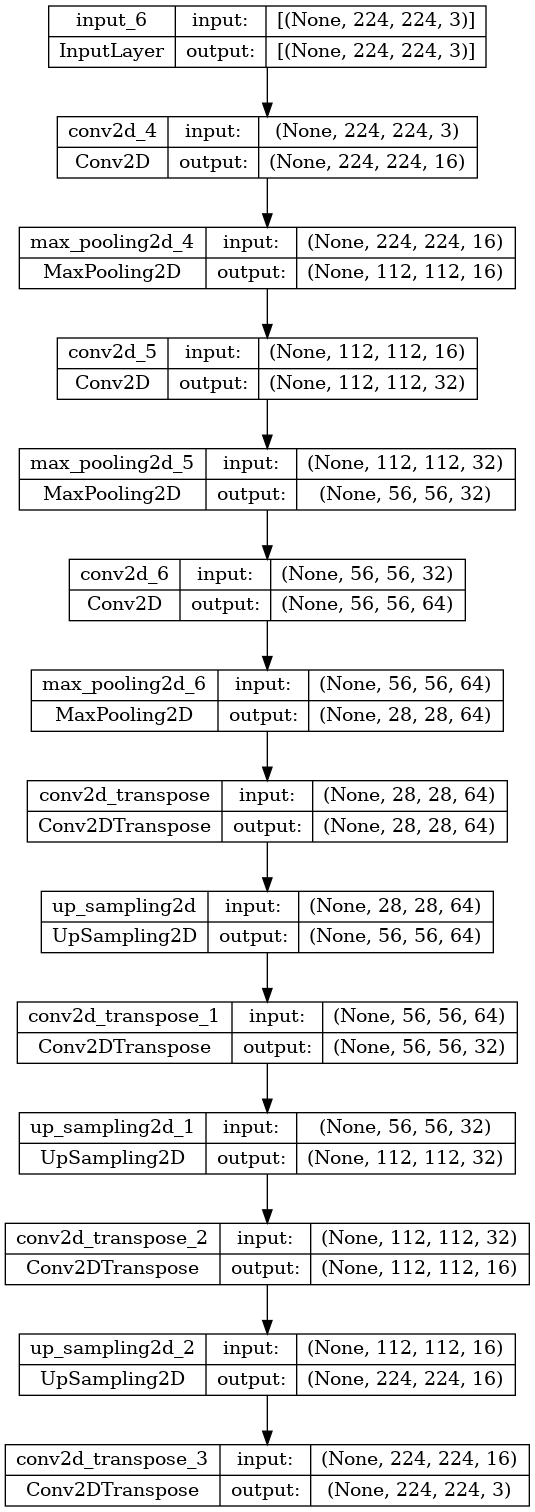

In [41]:
keras.utils.plot_model(model3,show_shapes=True)

In [42]:
# Compilación de la red
model3.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              run_eagerly=True)

In [43]:
# Entrenamiento de la red

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_weights_3.h5', 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         mode='max', 
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                           patience=10)

start_time = time.time()
history = model3.fit(train_data_auto,
                    epochs=100,
                    validation_data=(val_data_auto),
                    callbacks=[checkpoint_callback, early_stopping_callback])
end_time = time.time()

training_time = end_time - start_time

Epoch 1/100
230/230 [==============================] - 41s 157ms/step - loss: 0.0151 - val_loss: 0.0075
Epoch 2/100
230/230 [==============================] - 40s 169ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 3/100
230/230 [==============================] - 40s 168ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/100
230/230 [==============================] - 36s 155ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 5/100
230/230 [==============================] - 37s 156ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 6/100
230/230 [==============================] - 40s 171ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/100
230/230 [==============================] - 37s 155ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 8/100
230/230 [==============================] - 40s 170ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/100
230/230 [==============================] - 40s 171ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/100
230/230 [==============================] - 36s 155m

In [44]:
print("Training time: {} seconds".format(round(training_time,2)))

Training time: 3942.44 seconds


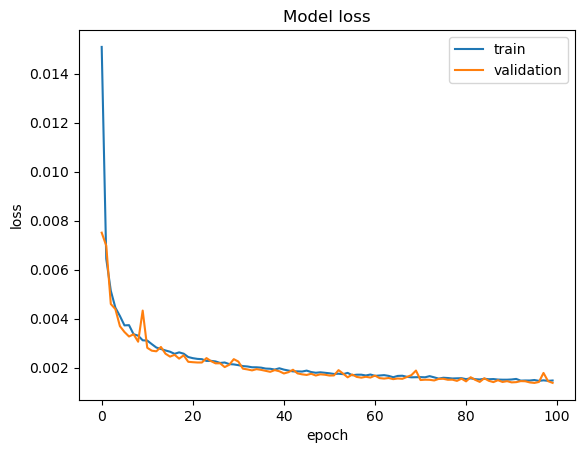

In [45]:
# Representación del loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### 4.2. Evaluación del autoencoder

La evaluación del modelo obtenido puede hacerse en este caso tanto de forma cuantitativa (calculando el MSE entre las imágenes originales y reconstruídas del conjunto de test) como cualitativa (mostrando imágenes originales y reconstruídas).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Realizar las siguientes operaciones para evaluar las prestaciones del modelo obtenido:
    <ul>
        <li>Partiendo del conjunto de test obtenido en el primer apartado de la practica:
            <ul>
                <li>Llevar a cabo el reescalado de los datos utilizando la capa <code>normalization_layer</code> tal y como se ha hecho con los conjuntos de entrenamiento y test al inicio de este bloque.</li>
                <li>Generar el conjunto de datos <code>test_data_auto</code> en el que las imágenes sean también el objetivo y substituyan a las etiquetas. </li>
            </ul></li>
        <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
        <li>Imprimir por pantalla 4 parejas de imágenes (original y reconstruída). Nota: a la hora de representar las imágenes correctamente, recordad que su rango dinámico deben ser números enteros entre 0 y 255.</li>
    </ul>
    Preguntas: ¿Consideras que la reconstrucción es adecuada? ¿Qué <i>ratio</i> de compresión se consigue con este autoencoder? Consideramos como <i>ratio</i> de compresión la relación entre el tamaño original de la imagen (224,224,3) y el de la representación más perqueña que llega a hacer el codificador (tamaño de la salida de su última capa).

In [46]:
# Normalización de los datos
normalized_test_data = test_data.map(lambda x, y: (normalization_layer(x), y))
test_data_auto = normalized_test_data.map(lambda x, y: (x, x))
image_batch, label_batch = iter(test_data_auto).get_next()
print("Las dimensiones de un batch de imágenes es: {}".format(image_batch.shape))
print("Las dimensiones de un batch de etiquetas es: {}".format(label_batch.shape))
first_image = image_batch[0]
print("En la primera imagen los valores mínimo y máximo son {} y {}, respectivamente"
      .format(np.min(first_image),np.max(first_image)))

Las dimensiones de un batch de imágenes es: (32, 224, 224, 3)
Las dimensiones de un batch de etiquetas es: (32, 224, 224, 3)
En la primera imagen los valores mínimo y máximo son 0.34609875082969666 y 0.9837952852249146, respectivamente


In [47]:
# Evaluación del modelo
loss = model3.evaluate(test_data_auto)
print('Test loss:', loss)

33/33 [==============================] - 4s 96ms/step - loss: 0.0014
Test loss: 0.0013876456068828702


In [48]:
for x_test, _ in test_data_auto.take(1):
    # Generate reconstructed images from the test set
    reconstructed = model3.predict(x_test)

1/1 [==============================] - 0s 93ms/step


In [49]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

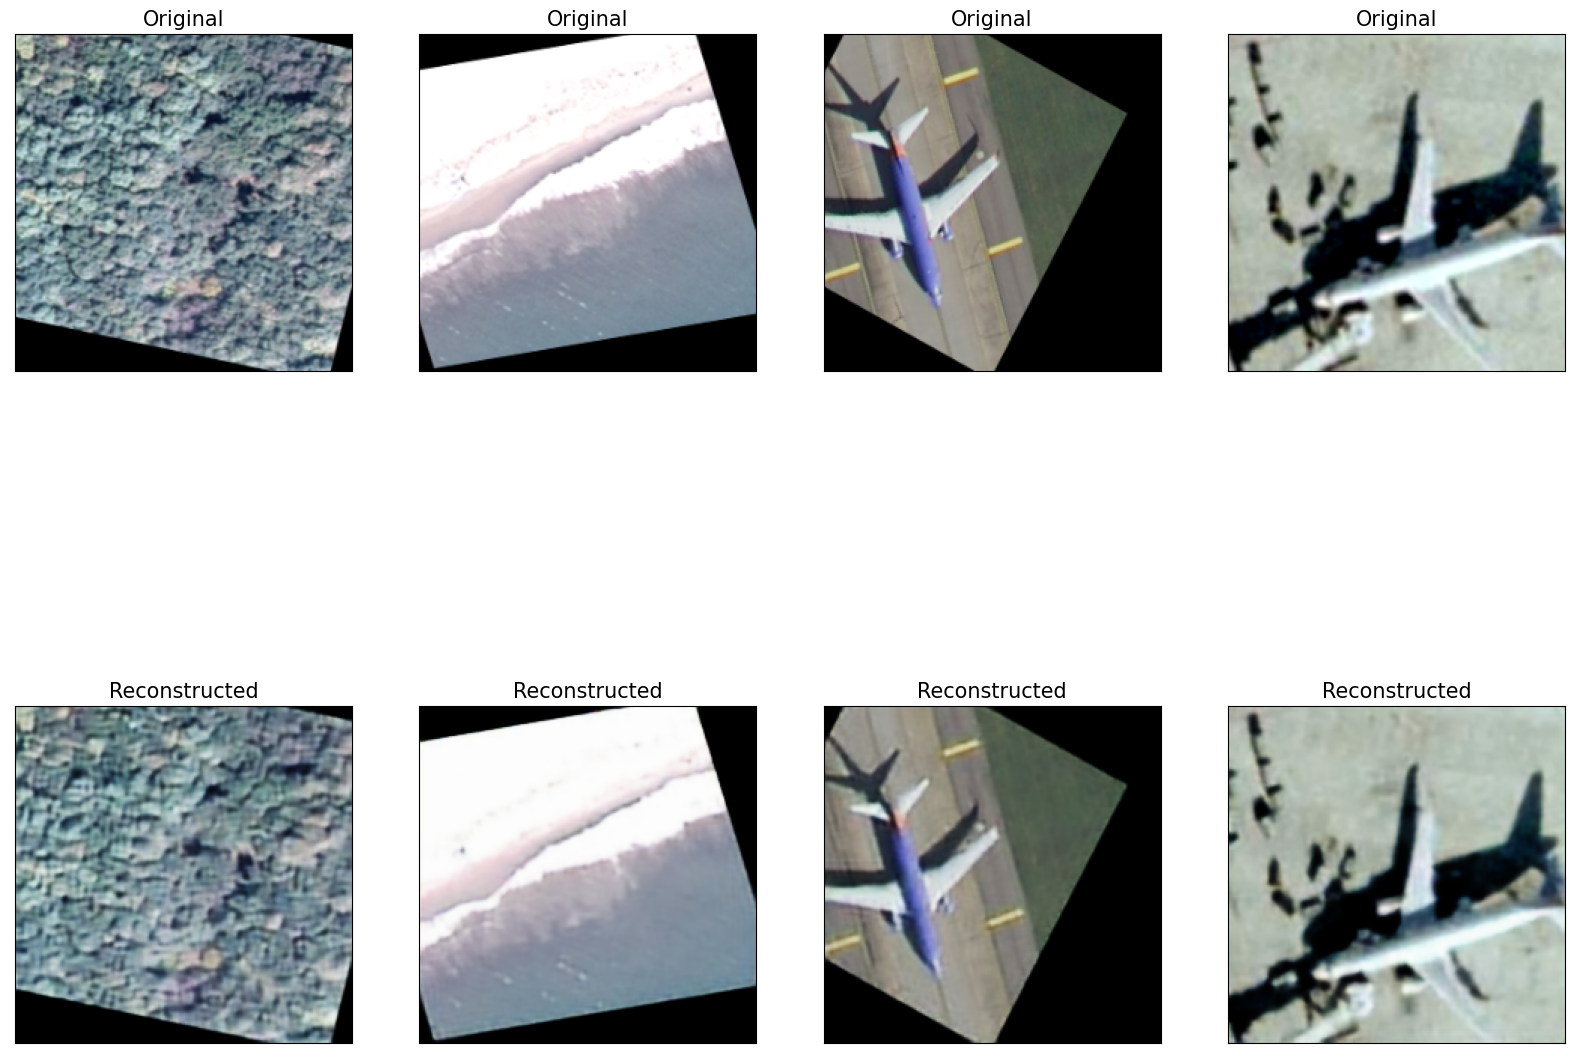

In [52]:
n = 4  # number of images to plot
plt.figure(figsize=(20, 16))
for i in range(n):
    # plot original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((x_test[i]*255).astype(np.uint8))
    plt.title('Original',fontsize=15)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed images
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow((reconstructed[i]*255).astype(np.uint8))
    plt.title('Reconstructed',fontsize=15)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
La reconstrucción es adecuada,se pueden identificar las imagenes perfectamente.
<br>
 El ratio de compresión es: 224/28 = 8
    <br>
    Tamaño de imagen origianr 224x224
    <br>
    Tamaño de imagen codificada: 28x28
<br><br>
</div>

## 5. Red VGG16 y transfer learning

Las redes neuronales convolucionales profundas nos brindan la posibilidad de mejorar la capacidad de aprendizaje de un modelo. Algunas arquitecturas comunes, pueden incluir cientos de capas convolucionales. No obstante, entrenar estas arquitecturas desde cero puede resultar costoso tanto en términos de tiempo como de recursos, además de requerir conjuntos de datos bastante grandes.

### 5.1. Transfer Learning
En este apartado, aplicaremos [transfer learning](https://keras.io/guides/transfer_learning/) con el fin de ahorrarnos parte de dicho entrenamiento. Esta metodología consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra tarea. En concreto, utilizaremos el modelo [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) preentrenado en [Imagenet](http://www.image-net.org/), y lo adaptaremos para clasificar las 21 categorías de nuestra base de datos. En la versión de VGG16 de keras existe la opción de cargar los pesos entrenados en Imagenet sin las 3 capas totalmente conectadas de la parte final de la red (opción <code>include_top = False</code>), nosotros substituiremos esas 3 capas y reentrenaremos el conjunto con el resto de pesos congelados.

Para reutilizar el modelo correctamente es necesario preprocesar los datos tal y como se hizo durante el entrenamiento en la base de datos original. Keras nos facilita aplicar la normalización en el caso de modelos preentrenados; para el caso de VGG16 revisar la documentación de [prepocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) (tened en cuenta que la función se aplica sobre imágenes con rango dinámico de 0 a 255).


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Implementa una red siguiendo los siguientes pasos:
    <ul>
        <li>Partir del modelo VGG16 con los pesos entrenados en Imagenet y congelarlos</li>
        <li>Substituir las 3 últimas capas completamente conectadas por 3 capas nuevas: las 2 primeras de 50 y 20 neuronas respectivamente con activación ReLU, y una última capa con el número de neuronas adecuado para llevar a cabo la tarea de clasificación sobre nuestra base de datos y la función de activación adecuada.</li> 
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorear la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
vgg16_model = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [14]:
# Definición de la red

#Frizamos todas las capas del modelo para que no se vuelvan a entrenar:
for layer in vgg16_model.layers:
    layer.trainable = False

#Defino las nuevas 3 capas:
flatten_layer = tf.keras.layers.Flatten()
hidden1_layer = tf.keras.layers.Dense(50,activation='relu')
hidden2_layer = tf.keras.layers.Dense(20,activation='relu')
output_layer = tf.keras.layers.Dense(21,activation=tf.keras.activations.softmax)

flatten = flatten_layer(vgg16_model.output)
hidden1 = hidden1_layer(flatten)
hidden2 = hidden2_layer(hidden1)
output = output_layer(hidden2)

model4 = tf.keras.Model(inputs=vgg16_model.input, outputs=output)

In [15]:
print(model4.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

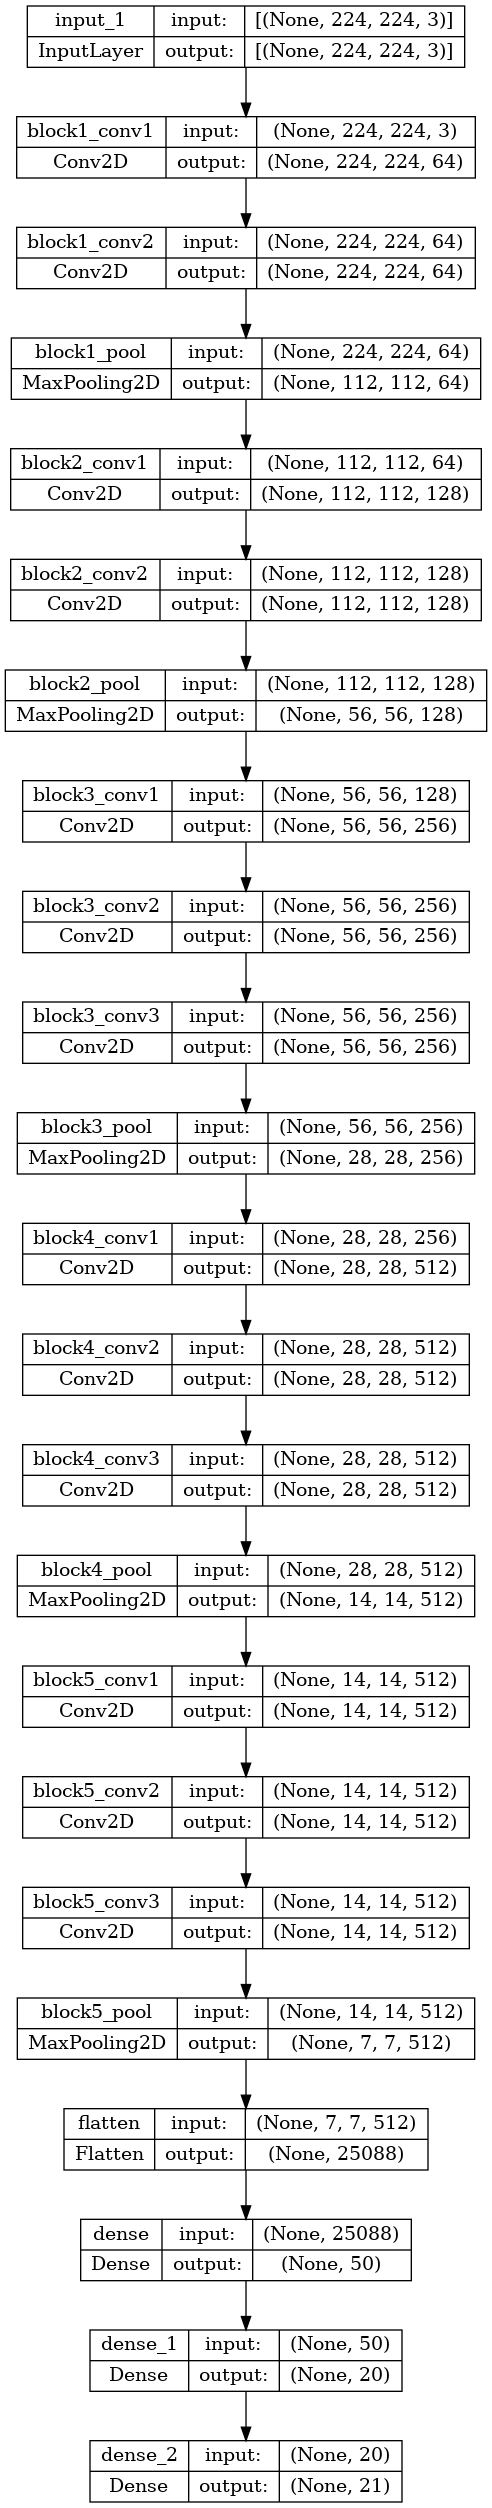

In [16]:
keras.utils.plot_model(model4,show_shapes=True)

In [17]:
# Compilación de la red
model4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"],
              run_eagerly=True)

In [30]:
#Uso la funcion proprocess_input para preparar los datos antes de entrenar el modelo VGG16:
train_vgg16 = train_data.map(lambda x, y: (preprocess_input(x), y))
val_vgg16 = val_data.map(lambda x, y: (preprocess_input(x), y))
test_vgg16 = test_data.map(lambda x, y: (preprocess_input(x), y))

In [19]:
# Entrenamiento de la red

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_weights_4.h5', 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         mode='max', 
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                           patience=10)

start_time = time.time()
history = model4.fit(train_vgg16,
                    epochs=100,
                    validation_data=(val_vgg16),
                    callbacks=[checkpoint_callback, early_stopping_callback])
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
230/230 [==============================] - ETA: 0s - loss: 2.4448 - accuracy: 0.2763
Epoch 1: val_accuracy improved from -inf to 0.47714, saving model to best_model_weights_4.h5
230/230 [==============================] - 185s 738ms/step - loss: 2.4448 - accuracy: 0.2763 - val_loss: 1.6706 - val_accuracy: 0.4771
Epoch 2/100
230/230 [==============================] - ETA: 0s - loss: 1.0571 - accuracy: 0.6513
Epoch 2: val_accuracy improved from 0.47714 to 0.68095, saving model to best_model_weights_4.h5
230/230 [==============================] - 162s 703ms/step - loss: 1.0571 - accuracy: 0.6513 - val_loss: 1.0420 - val_accuracy: 0.6810
Epoch 3/100
230/230 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8797
Epoch 3: val_accuracy improved from 0.68095 to 0.76571, saving model to best_model_weights_4.h5
230/230 [==============================] - 163s 705ms/step - loss: 0.4064 - accuracy: 0.8797 - val_loss: 0.8600 - val_accuracy: 0.7657
Epoch 4/100
230/230

NameError: name 'end_time' is not defined

In [20]:
end_time = time.time()

In [21]:
training_time = end_time - start_time

In [22]:
#Pesos que mejor resultado dieron:
model4.load_weights('best_model_weights_4.h5')

In [23]:
# Resultados
print("Training time: {} seconds".format(round(training_time,2)))

Training time: 18045.09 seconds


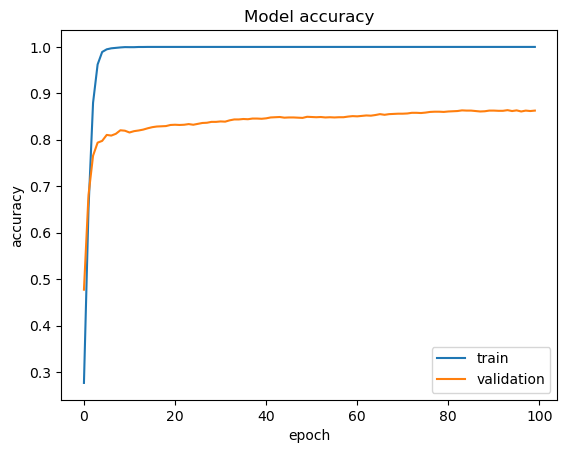

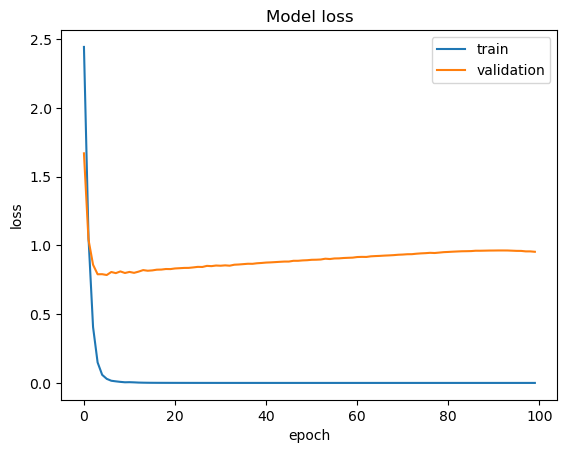

In [24]:
plot_neural_network(history)

In [25]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = model4.evaluate(test_vgg16)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

33/33 [==============================] - 12s 310ms/step - loss: 0.8605 - accuracy: 0.8752
Test loss: 0.8604841828346252
Test accuracy: 0.8752381205558777


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Del total de 15.970.599 parámetros, 1.255.911 son los parámetros a entrenar gracias al transfer learning. 
    <br>
    El tiempo de entrenamiento fue de 18000 segundos que equivale a aproximadamente 300 minutos.
    <br>
 La accuracy obtenida utilizando este modelo es mejor que las anteriores: 0,875 y el loss es 0,86. En las gráficas podemos ver como el accuracy aumenta rápidamente a partir de aproximadamente 10 épocas y luego sigue mejorando pero muy levemente. En la gráfica de 'loss' vemos que los valores del set de entrenamiento son bastante mejores que los del set de validación, y en los dos casos llegan a un mínimo a partir de aproximadamente 5 épocas y luego se van redujendo levemente, aunque si evaluamos el comportamiento del set de validación a partir de aproximadamente 20 épocas, comienza a aumentar levemente a medida que seguimos aumentando las épocas.
 <br><br>
</div>

### 5.2. Fine-tunning
Una técnica frecuente, sobretodo cuando la red utilizada no es excesivamente grande (como es el caso de VGG16), para mejorar los resultados del <i>transfer learning</i> es el denominado <i>fine-tunning</i>,  que consiste en reentrenar la red completa durante unas pocas épocas y con un <i>learning rate</i> muy pequeño.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Volver a compilar el modelo con los siguientes cambios:
    <ul>
        <li>Descongelar los pesos del modelo VGG16 poniendo <code>trainable=False</code> (no confundir con <code>traning=False</code>).</li>
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.00001.</li>
         <li>Entrenar durante 10 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados teniendo en cuenta el proceso global: <i>transfer lerning</i> + <i> fine-tunning</i>.
</div>


In [26]:
# Definición de la red

#Desfrizamos todas las capas del modelo para que se vuelvan a entrenar:
for layer in vgg16_model.layers:
    layer.trainable = True

In [27]:
# Compilación de la red
model4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"],
              run_eagerly=True)

In [28]:
print(model4.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
# Entrenamiento de la red

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_weights_5.h5', 
                                                         monitor='val_accuracy', 
                                                         save_best_only=True, 
                                                         mode='max', 
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                           patience=10)

start_time = time.time()
history = model4.fit(train_vgg16,
                    epochs=10,
                    validation_data=(val_vgg16),
                    callbacks=[checkpoint_callback, early_stopping_callback])
end_time = time.time()

training_time = end_time - start_time

Epoch 1/10
230/230 [==============================] - ETA: 0s - loss: 1.6332e-08 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.86238, saving model to best_model_weights_5.h5
230/230 [==============================] - 169s 712ms/step - loss: 1.6332e-08 - accuracy: 1.0000 - val_loss: 0.9842 - val_accuracy: 0.8624
Epoch 2/10
230/230 [==============================] - ETA: 0s - loss: 1.1159e-08 - accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.86238 to 0.86381, saving model to best_model_weights_5.h5
230/230 [==============================] - 170s 736ms/step - loss: 1.1159e-08 - accuracy: 1.0000 - val_loss: 0.9839 - val_accuracy: 0.8638
Epoch 3/10
230/230 [==============================] - ETA: 0s - loss: 1.0721e-08 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.86381 to 0.86476, saving model to best_model_weights_5.h5
230/230 [==============================] - 169s 733ms/step - loss: 1.0721e-08 - accuracy: 1.0000 - val_loss: 0.9830 - val_accuracy: 0.864

In [ ]:
#Pesos que mejor resultado dieron:
model4.load_weights('best_model_weights_5.h5')

In [30]:
# Resultados
print("Training time: {} seconds".format(round(training_time,2)))

Training time: 1825.21 seconds


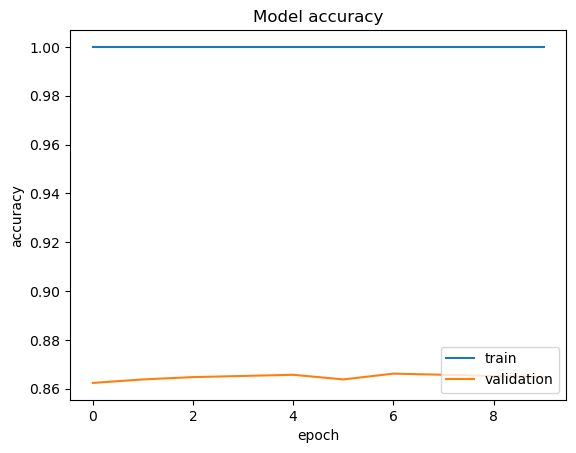

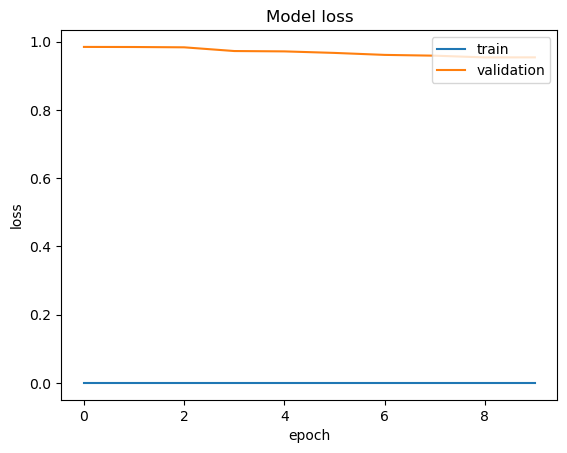

In [31]:
plot_neural_network(history)

In [32]:
# Evaluate the model on the test data using `evaluate`
loss, accuracy = model4.evaluate(test_vgg16)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

33/33 [==============================] - 8s 200ms/step - loss: 0.8526 - accuracy: 0.8838
Test loss: 0.852575421333313
Test accuracy: 0.883809506893158


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    En este caso el total de los parámetros se entrarán, es decir los 15.970.599. 
    <br>
    El tiempo de entrenamiento fue de 1733 segundos que equivale a 28 minutos.
    <br>
 La accuracy obtenida utilizando este modelo es: 0,878, ha mejorado muy poco con respecto al modelo anterior que era 0,875. El loss es 1,06. 
    <br>
    En las gráficas podemos ver el comportamiento del modelo con los set de entrenamiento y de validación, vemos que el accuracy y el lost son mejores en el primero que en el segundo, lo cual es un comportamiento esperable, pero dado los resultados obtenidos con el set de validación podemos decir que el modelo generaliza bien.
   <br><br>
</div>

## 6. Mejora de resultados
En este último apartado se deja libertad al alumno para conseguir, mediante el diseño de una red propia, unos mejores resultados en la tarea de clasificación.

Se valorarará la justificación de las elecciones realizadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Implementar un modelo para llevar a cabo la tarea de clasificación:
    <ul>
        <li>Diseñar la arquitectura de la red</li>
        <li>Compilar el modelo</li>
        <li>Llevar a cabo el entrenamientio</li>
        <li>Evaluar el modelo presentando las métricas y gráficas adecuadas</li>
        <li>Comentar los resultados obtenidos</li>
    </ul>
</div>

In [33]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Frizo las capas del modelo VGG16
for layer in vgg16.layers:
    layer.trainable = False

# Definicion del modelo:
model6 = tf.keras.models.Sequential([
    vgg16,
    Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(21, activation='softmax')
])


In [34]:
model6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               2359808   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                      

In [35]:
# Compilo el modelo
model6.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              metrics=['accuracy'])

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
start_time = time.time()
history = model6.fit(train_vgg16, epochs=100, validation_data=(val_vgg16), callbacks=[callback])
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
230/230 [==============================] - 101s 346ms/step - loss: 10.2121 - accuracy: 0.0683 - val_loss: 2.9262 - val_accuracy: 0.1895
Epoch 2/100
230/230 [==============================] - 61s 261ms/step - loss: 4.5784 - accuracy: 0.0996 - val_loss: 2.6368 - val_accuracy: 0.2271
Epoch 3/100
230/230 [==============================] - 61s 261ms/step - loss: 3.3971 - accuracy: 0.1192 - val_loss: 2.6365 - val_accuracy: 0.2595
Epoch 4/100
230/230 [==============================] - 52s 223ms/step - loss: 3.0255 - accuracy: 0.1388 - val_loss: 2.6030 - val_accuracy: 0.2829
Epoch 5/100
230/230 [==============================] - 62s 265ms/step - loss: 2.8728 - accuracy: 0.1562 - val_loss: 2.5171 - val_accuracy: 0.3210
Epoch 6/100
230/230 [==============================] - 53s 226ms/step - loss: 2.7321 - accuracy: 0.1932 - val_loss: 2.4119 - val_accuracy: 0.3652
Epoch 7/100
230/230 [==============================] - 61s 262ms/step - loss: 2.6389 - accuracy: 0.2186 - val_loss: 2.2369

In [37]:
# Evaluo el modelo con el set de testeo
test_loss, test_accuracy = model6.evaluate(test_vgg16)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

33/33 [==============================] - 13s 363ms/step - loss: 0.3370 - accuracy: 0.9114
Test loss: 0.33698567748069763
Test accuracy: 0.9114285707473755


In [38]:
# Resultados
print("Training time: {} seconds".format(round(training_time,2)))


Training time: 6825.81 seconds


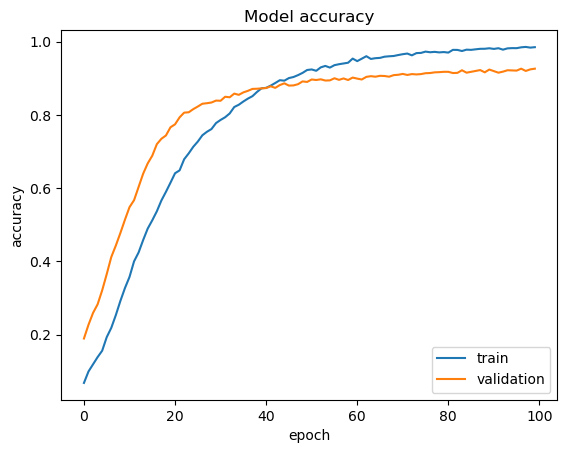

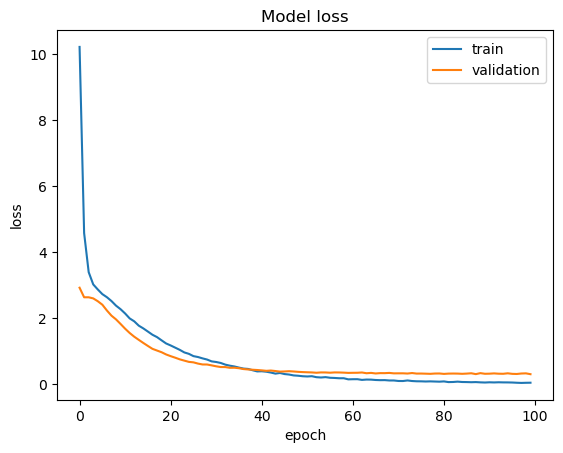

In [39]:
plot_neural_network(history)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Utilizando esta última red neuronal vemos que la métrica ‘accuracy’ ha mejorado mucho, llegando a 0,91 evaluando el modelo con el set de test.
    <br>
El modelo que decidí usar está formado por la red VGG16 pre entrenada, modificando las últimas tres capas completamente conectadas por las siguientes capas y manteniendo los pesos del modelo original.
    <br>
La primera capa que recibe la salida del modelo vgg16 es una capa convolutional con 512 filtros, un kernel de tamaño (3,3) y una función de activación ReLU. Luego sigue una capa MaxPooling2D para reducir la dimension de la salida. 
    <br>
La salida de la capa max pooling luego pasa por una capa flatten para convertir los datos a un vector unidimensional para que puedan utilizarse como entrada de las capas completamente conectadas siguientes para la tarea de clasificación, con 512 y 256 unidades respectivamente y ambas con activación ReLU. La salida ingresa a una capa dropout con probabilidad 0,5.  El beneficio de usar una capa de dropout luego de una convolucional es evitar el overfitting y mejorar la performance del modelo con datos que no conoce. Al usar un ratio de 0,5 en las capas dropout le estamos indicando que el 50% de los datos que ingresan a esta capa serán modificados a cero de forma aleatoria, con el objetivo de evitar el sobre entrenamiento.
Finalmente, la capa de salida del modelo tiene 21 unidades que representan las 21 clases y una función de activación softmax.
<br>
La mejora en la performance del modelo tiene que ver, por un lado gracias al uso de los pesos pre calculados del modelo vgg16 que está entrenado con una base de datos de muy alto volumen de imágenes. Por otro lado, el uso de las dos capas completamente conectadas de 512 y 256 neuronas, que le permiten al modelo interpretar las representaciones más complejas de las imágenes, y también el agregado de la capa dropout para evitar el overfitting y permitir que la red pueda generalizar la clasificación para imágenes que nunca vio.
<br><br>
</div>